In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import glob
import imageio
import PIL
import cv2
from IPython import display

## Generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16 * 16 * 512, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((16, 16, 512)))
    assert model.output_shape == (None, 16, 16, 512)

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 128, 128, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 256, 256, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(2, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 512, 512, 2)

    return model

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

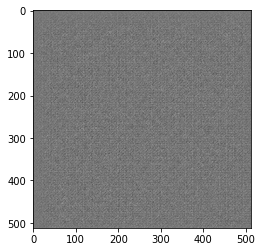

In [ ]:
plt.imshow(generated_image[0, :, :, 1], cmap='gray')

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Dyskryminator

In [ ]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[512, 512, 2]))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.5, beta_2=0.999)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/WarsztatyBadawcze/GAN/training_checkpoints_3'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
EPOCHS = 200
BATCH_SIZE = 16
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 8))

  for i in range(0, predictions.shape[0] * 2, 2):
      plt.subplot(8, 4, i+1)
      plt.imshow(predictions[int(i//2), :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
      plt.subplot(8, 4, i+2)
      plt.imshow(predictions[int(i//2), :, :, 1], cmap='gray')
      plt.axis('off')

  plt.savefig('/content/drive/MyDrive/WarsztatyBadawcze/GAN/generated_images_3/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


## Trenowanie
1. Wczytujemy dane 
2. Dane podane do modelu są znormalizowane w zakresie [-1, 1].
3. Dane podawane do modelu składają się ze zdjęcia i odpowiadającej jemu maski. Czyli mają wymiar [512, 512, 2].

In [ ]:
train_images = np.load('/content/drive/MyDrive/WarsztatyBadawcze/processed_data/data_train.npy')
train_masks = np.load('/content/drive/MyDrive/WarsztatyBadawcze/processed_data/mask_train.npy')

In [ ]:
train_images = train_images.reshape(714, 1, 512, 512)
train_masks = train_masks.reshape(714, 1, 512, 512)

In [ ]:
train_images = (train_images - 127.5) / 127.5 

In [ ]:
train_dataset = np.concatenate((train_images, train_masks), axis=1)

In [ ]:
train_dataset.shape

(714, 2, 512, 512)

In [ ]:
train_dataset = np.moveaxis(train_dataset, 1, 3)
train_dataset.shape

(714, 512, 512, 2)

In [ ]:
BUFFER_SIZE = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/WarsztatyBadawcze/GAN/training_checkpoints_3/checkpoint_f'
os.listdir(checkpoint_dir)
checkpoint_path = "/content/drive/MyDrive/WarsztatyBadawcze/GAN/training_checkpoints_3/checkpoint_f/ckpt-4"

In [ ]:
ckpt1 = tf.train.Checkpoint(generator=make_generator_model())
ckpt1.restore(checkpoint_path).expect_partial()
generator = ckpt1.generator

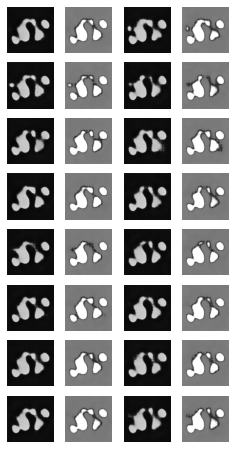

Time for epoch 70 is 98.20649814605713 sec


In [ ]:
train(train_dataset, 100)